Assignment 2 : d2l - Section 6.6.4 - Question 2
modified hyperparameters 

In [1]:
import tensorflow as tf
from d2l import tensorflow as d2l

def net():
    return tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=6, kernel_size=5, activation='sigmoid',
                               padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=1),
        tf.keras.layers.Conv2D(filters=16, kernel_size=5,
                               activation='sigmoid'),
        tf.keras.layers.MaxPool2D(pool_size=2, strides=1),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(120, activation='sigmoid'),
        tf.keras.layers.Dense(84, activation='sigmoid'),
        tf.keras.layers.Dense(10)])

In [2]:
X = tf.random.uniform((1, 28, 28, 1))
for layer in net().layers:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape: \t', X.shape)

Conv2D output shape: 	 (1, 28, 28, 6)
MaxPooling2D output shape: 	 (1, 27, 27, 6)
Conv2D output shape: 	 (1, 23, 23, 16)
MaxPooling2D output shape: 	 (1, 22, 22, 16)
Flatten output shape: 	 (1, 7744)
Dense output shape: 	 (1, 120)
Dense output shape: 	 (1, 84)
Dense output shape: 	 (1, 10)


In [3]:
batch_size = 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

4431872/4422102 [==============================] - 0s 0us/step


In [4]:
class TrainCallback(tf.keras.callbacks.Callback):  #@save
    """A callback to visiualize the training progress."""
    def __init__(self, net, train_iter, test_iter, num_epochs, device_name):
        self.timer = d2l.Timer()
        self.animator = d2l.Animator(
            xlabel='epoch', xlim=[1, num_epochs],
            legend=['train loss', 'train acc', 'test acc'])
        self.net = net
        self.train_iter = train_iter
        self.test_iter = test_iter
        self.num_epochs = num_epochs
        self.device_name = device_name

    def on_epoch_begin(self, epoch, logs=None):
        self.timer.start()

    def on_epoch_end(self, epoch, logs):
        self.timer.stop()
        test_acc = self.net.evaluate(self.test_iter, verbose=0,
                                     return_dict=True)['accuracy']
        metrics = (logs['loss'], logs['accuracy'], test_acc)
        self.animator.add(epoch + 1, metrics)
        if epoch == self.num_epochs - 1:
            batch_size = next(iter(self.train_iter))[0].shape[0]
            num_examples = batch_size * tf.data.experimental.cardinality(
                self.train_iter).numpy()
            print(f'loss {metrics[0]:.3f}, train acc {metrics[1]:.3f}, '
                  f'test acc {metrics[2]:.3f}')
            print(f'{num_examples / self.timer.avg():.1f} examples/sec on '
                  f'{str(self.device_name)}')

#@save
def train_ch6(net_fn, train_iter, test_iter, num_epochs, lr, device):
    """Train a model with a GPU (defined in Chapter 6)."""
    device_name = device._device_name
    strategy = tf.distribute.OneDeviceStrategy(device_name)
    with strategy.scope():
        optimizer = tf.keras.optimizers.SGD(learning_rate=lr)
        loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        net = net_fn()
        net.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
    callback = TrainCallback(net, train_iter, test_iter, num_epochs,
                             device_name)
    net.fit(train_iter, epochs=num_epochs, verbose=0, callbacks=[callback])
    return net

loss 0.180, train acc 0.932, test acc 0.907
1286.9 examples/sec on /CPU:0


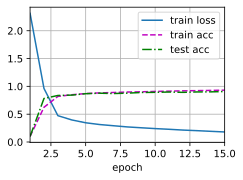

In [5]:
lr, num_epochs = 1.24, 15
train_net = train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())

In [ ]:
# Print all layers in network
print(train_net.layers)

netFirstLayer = tf.keras.Sequential(train_net.layers[0])
netSecondLayer = tf.keras.Sequential(train_net.layers[0:3])

# Print first and second layers of network
print(netFirstLayer.layers)
print(netSecondLayer.layers)

netFirstLayer.add(tf.keras.layers.Flatten())
netFirstLayer.add(tf.keras.layers.Dense(120, activation='sigmoid'))
netFirstLayer.add(tf.keras.layers.Dense(84, activation='sigmoid'))
netFirstLayer.add(tf.keras.layers.Dense(10))

netSecondLayer.add(tf.keras.layers.Flatten())
netSecondLayer.add(tf.keras.layers.Dense(120, activation='sigmoid'))
netSecondLayer.add(tf.keras.layers.Dense(84, activation='sigmoid'))
netSecondLayer.add(tf.keras.layers.Dense(10))

print("First Layer: ")
d2l.predict_ch3(netFirstLayer, test_iter)

print("Second Layer: ")
d2l.predict_ch3(netSecondLayer, test_iter)

print("Full Connect: ")
d2l.predict_ch3(train_net, test_iter)